In [2]:

# import basic modules
import sys
import os
import time
import numpy as np
from tqdm import tqdm
import gc
import torch
import argparse
import skimage.transform

# import custom modules
code_dir = '/user_data/mmhender/imStat/code/'
sys.path.append(code_dir)
from feature_extraction import texture_statistics_gabor, bdcn_features, sketch_token_features
from feature_extraction import texture_statistics_pyramid, alexnet_features
from utils import nsd_utils, roi_utils, default_paths

from model_fitting import initialize_fitting as initialize_fitting
from model_fitting import arg_parser as arg_parser
from model_fitting import merge_features, fwrf_fit, fwrf_predict, reconstruct

fpX = np.float32
# device = initialize_fitting.init_cuda()
device = 'cpu:0'
# device = initialize_fitting.init_cuda()

In [3]:
fitting_type='alexnet';
alexnet_layer_name = 'Conv5_ReLU'

subject=1; volume_space = True; up_to_sess = 40;

n_ori = 4; n_sf = 4; nonlin_fn = False;  padding_mode = 'circular'; \
group_all_hl_feats = True; 

sample_batch_size = 50; voxel_batch_size = 100; \

zscore_features = True; zscore_in_groups = False; ridge = True; \
shuffle_images = False; random_images = False; random_voxel_data = False; \
do_fitting = True; use_precomputed_prfs = False; do_val = True; do_stack=True; \
do_varpart = True; do_roi_recons=False; do_voxel_recons=False; date_str = None; \

shuff_rnd_seed = 291922; 
debug = True;

use_pca_st_feats = False; use_lda_st_feats = False; lda_discrim_type = None; \
do_pca_bdcn = True; use_pca_pyr_feats_ll = False; use_pca_pyr_feats_hl = False;\

min_pct_var = 99; max_pc_to_retain = 400; \
max_pc_to_retain_pyr_ll = 100; max_pc_to_retain_pyr_hl = 100;\
map_ind = -1; n_prf_sd_out = 2; mult_patch_by_prf = True; \
downsample_factor = 1.0; do_nms = False

In [126]:
model_name

'alexnet_Conv5'

In [4]:
output_dir, fn2save = initialize_fitting.get_save_path(subject, volume_space, model_name, shuffle_images, \
                                                           random_images, random_voxel_data, debug, date_str)
    

NameError: name 'model_name' is not defined

In [1]:
trn_stim_data

NameError: name 'trn_stim_data' is not defined

In [88]:
# decide what voxels to use  
voxel_mask, voxel_index, voxel_roi, voxel_ncsnr, brain_nii_shape = roi_utils.get_voxel_roi_info(subject, \
                                                        volume_space, include_all=True, include_body=True)

sessions = np.arange(0,up_to_sess)
zscore_betas_within_sess = True
# get all data and corresponding images, in two splits. always fixed set that gets left out
trn_stim_data, trn_voxel_data, val_stim_data, val_voxel_data, \
        image_order, image_order_trn, image_order_val = nsd_utils.get_data_splits(subject, \
                                  sessions=sessions, image_inds_only = True, \
                                  voxel_mask=voxel_mask, volume_space=volume_space, \
                                  zscore_betas_within_sess=zscore_betas_within_sess, \
                              shuffle_images=shuffle_images, random_images=random_images, \
                                random_voxel_data=random_voxel_data)



Volume space: ROI defs are located at: /lab_data/tarrlab/common/datasets/NSD/nsddata/ppdata/subj01/func1pt8mm/roi

3794 voxels of overlap between kastner and prf definitions, using prf defs
unique values in retino labels:
[-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25.]
unique values in face labels:
[-1.  0.  1.  2.  3.  5.]
unique values in place labels:
[-1.  0.  1.  2.  3.]
unique values in body labels:
[-1.  0.  1.  2.  3.]
1987 voxels are defined (differently) in both retinotopic areas and category areas
0 voxels are defined (differently) in both face areas and place areas
490 voxels are defined (differently) in both face areas and body areas
158 voxels are defined (differently) in both place areas and body areas
Including all voxels that are defined within nsdgeneral mask, in addition to roi labels.

19738 voxels are defined across all areas, and will be used for analysis

Loading numerical label/name mappings for all

In [89]:
# More params for fitting
holdout_size, lambdas = initialize_fitting.get_fitting_pars(trn_voxel_data, zscore_features, ridge=ridge)
# Params for the spatial aspect of the model (possible pRFs)
aperture_rf_range = 1.1
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range) 



Possible lambda values are:
[1.0000000e+00 4.2169652e+00 1.7782795e+01 7.4989418e+01 3.1622775e+02
 1.3335215e+03 5.6234131e+03 2.3713736e+04 1.0000000e+05]
most extreme RF positions:
[-0.55 -0.55  0.04]
[0.55       0.55       0.40000001]


In [90]:
# alexnet_layer_name = 'Conv5_ReLU'
# # alexnet_layer_name = 'all_conv'
# fitting_type2='sketch_tokens'

if alexnet_layer_name=='all_conv':
    assert(fitting_type2 is None)
    fe = []
    n_layers = 5
    names = ['Conv%d_ReLU'%(ll+1) for ll in range(n_layers)]
    for ll in range(n_layers):
        fe.append(alexnet_feature_extractor(subject=subject, \
                                                     layer_name=names[ll], device=device))
    _feature_extractor = merge_features.combined_feature_extractor(fe, names, do_varpart=do_varpart)

else:
    _feature_extractor = alexnet_features.alexnet_feature_extractor(subject=subject, \
                                                     layer_name=alexnet_layer_name, device=device)
    


In [175]:
_feature_extractor.n_features

256

In [91]:
_feature_extractor.init_for_fitting(image_size=(240,240), models=models, dtype=fpX)

Initializing for fitting
Clearing features from memory


In [94]:
mm = 866
f, defined = _feature_extractor(image_order_val, models[mm,:], mm)
f = f.detach().cpu().numpy()

Index into batch for prf 866: 66
Size of features array for this image set and prf is:
(3000, 256)
Final size of feature matrix is:
(3000, 256)


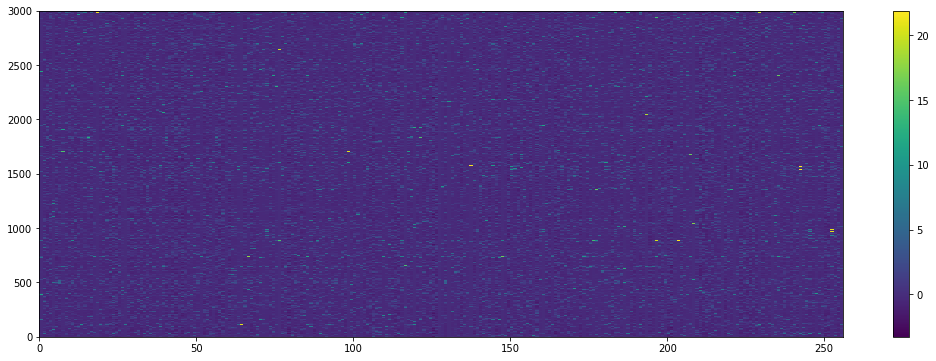

In [95]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,6));
features_m = np.mean(f, axis=0, keepdims=True) #[:trn_size]
features_s = np.std(f, axis=0, keepdims=True) + 1e-6     
fz = (f - features_m) / features_s
plt.pcolormesh(fz)
plt.colorbar()

In [99]:
images = image_order_trn;
voxel_data = trn_voxel_data;
_feature_extractor = _feature_extractor;
prf_models = models;
lambdas=lambdas;
best_model_each_voxel=None;
zscore=True;
add_bias=True;
voxel_batch_size=100;
holdout_size=holdout_size;
shuffle=True; shuff_rnd_seed=291922; device=device; dtype=np.float32; 

In [100]:

if device is None:
    device=torch.device('cpu:0')

print ('dtype = %s' % dtype)
print ('device = %s' % device)

n_trials = len(images)
n_prfs = len(prf_models)
n_voxels = voxel_data.shape[1]   

# Get train/holdout splits.
# Held-out data here is used for lamdba selection.
# This is the inner part of nested cross-validation; there is another portion of data ('val')
# which never enters this function.
trn_size = n_trials - holdout_size
assert trn_size>0, 'Training size needs to be greater than zero'
print ('trn_size = %d (%.1f%%)' % (trn_size, float(trn_size)*100/len(voxel_data)))
order = np.arange(len(voxel_data), dtype=int)
if shuffle:
    if shuff_rnd_seed==0:
        print('Computing a new random seed')
        shuff_rnd_seed = int(time.strftime('%M%H%d', time.localtime()))
    print('Seeding random number generator: seed is %d'%shuff_rnd_seed)
    np.random.seed(shuff_rnd_seed)
    np.random.shuffle(order)

images = images[order]

train_trial_order = order[:trn_size]
holdout_trial_order = order[trn_size:]

trn_data = copy.deepcopy(voxel_data[train_trial_order,:])
out_data = copy.deepcopy(voxel_data[holdout_trial_order,:])


# Here is where any model-specific additional initialization steps are done
# Includes initializing pca params arrays, if doing pca
if len(images.shape)>1:
    image_size = images.shape[2:4]
else:
    image_size = None
_feature_extractor.init_for_fitting(image_size, prf_models, dtype)
max_features = _feature_extractor.max_features

# Decide whether to do any "partial" versions of the models (leaving out subsets of features)
# Purpose is for variance partition
masks, partial_version_names = _feature_extractor.get_partial_versions()
n_partial_versions = len(partial_version_names) # will be one if skipping varpart
if add_bias:
    masks = np.concatenate([masks, np.ones([masks.shape[0],1])], axis=1) # always include intercept 
masks = np.transpose(masks)
# masks is [n_features_total (including intercept) x n_partial_versions]

# Initialize arrays to store model fitting params
best_w_params = None
best_prf_models = None
best_lambdas = None
best_losses = None

# Initialize arrays to store the trial-wise predictions (need these for stacking)
# Using JUST the held out trials here so the errors are always cross-validated
best_train_holdout_preds = None

# Additional params that are optional
if add_bias:
    best_w_params = None
if zscore:
    if hasattr(_feature_extractor, 'zgroup_labels') and \
                    _feature_extractor.zgroup_labels is not None:
        zscore_in_groups = True
        features_mean = None
        features_std = None
        zgroup_labels = _feature_extractor.zgroup_labels
        print('will z-score columns in groups')
    else:
        zscore_in_groups = False
        features_mean = np.zeros(shape=(n_prfs, max_features), dtype=dtype)
        features_std  = np.zeros(shape=(n_prfs, max_features), dtype=dtype)
        print('will z-score each column')
else:
    features_mean = None
    features_std = None
    print('will not z-score')

start_time = time.time()
vox_loop_time = 0

print ('---------------------------------------\n')


dtype = <class 'numpy.float32'>
device = cpu:0
trn_size = 24300 (90.0%)
Seeding random number generator: seed is 291922
Initializing for fitting
Clearing features from memory
will z-score each column
---------------------------------------



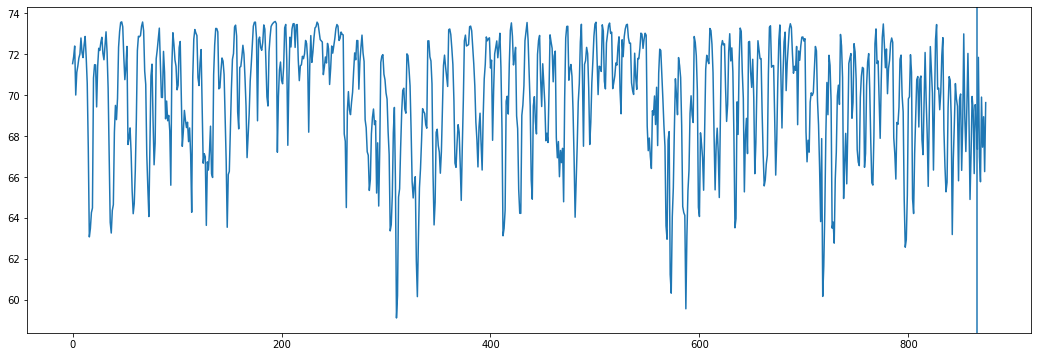

In [84]:
plt.figure(figsize=(18,6));
plt.plot(np.min(losses, axis=0))
plt.axvline(866)

In [80]:
np.argmin(np.min(losses, axis=0))

310

In [81]:
models[310,:]

array([0.02894737, 0.31842105, 0.04      ])

In [82]:
mind

866

In [ ]:
losses = np.zeros((len(lambdas), len(prf_models)))

for m,(x,y,sigma) in enumerate(prf_models):
    
    features, feature_inds_defined = _feature_extractor(images, (x,y,sigma), m, fitting_mode=True)
    features = features.detach().cpu().numpy() 
       
    n_features_actual = features.shape[1]

    if zscore:  
        if zscore_in_groups:
            features = numpy_utils.zscore_in_groups(features, zgroup_labels)
        else:
            # otherwise do each column separately, this is usual way
            features_m = np.mean(features, axis=0, keepdims=True) #[:trn_size]
            features_s = np.std(features, axis=0, keepdims=True) + 1e-6          
            features -= features_m
            features /= features_s   
            # saving these for later so we can exactly reproduce this normalization
            # when doing validation pass...
            features_mean[m,feature_inds_defined] = features_m
            features_std[m,feature_inds_defined] = features_s

    if add_bias:
        features = np.concatenate([features, np.ones(shape=(len(features), 1), dtype=dtype)], axis=1)
        feature_inds_defined = np.concatenate((feature_inds_defined, [True]), axis=0)

    trn_features = features[:trn_size,:]
    out_features = features[trn_size:,:]

    voxels_to_fit = np.array([vind])

    n_voxels_to_fit = len(voxels_to_fit)            
    n_voxel_batches = int(np.ceil(n_voxels_to_fit/voxel_batch_size))

    pp=0

    # nonzero_inds_full is length max_features (or max_features+1 if bias=True)
    # same size as the final params matrices will be.
    nonzero_inds_full = np.logical_and(masks[:,pp], feature_inds_defined)             
    # nonzero_inds_full is restricted to just indices that are defined for this prf - ie same size as features.
    nonzero_inds_short = masks[feature_inds_defined,pp]==1

    # Send matrices to gpu    
    _xtrn = torch_utils._to_torch(trn_features[:, nonzero_inds_short], device=device)
    _xout = torch_utils._to_torch(out_features[:, nonzero_inds_short], device=device)   

    # Do part of the matrix math involved in ridge regression optimization out of the loop, 
    # because this part will be same for all the voxels.
    _cof = _cofactor_fn_cpu(_xtrn, lambdas = lambdas) 

    # Now looping over batches of voxels (only reason is because can't store all in memory at same time)
    vox_start = time.time()

    for vi in range(n_voxel_batches):

        vinds = np.arange(voxel_batch_size*vi, np.min([voxel_batch_size*(vi+1), n_voxels_to_fit]))
        rv = voxels_to_fit[vinds]
        lv = len(vinds)

        sys.stdout.write('\rfitting model %4d of %-4d, voxel batch %d of %d'%(m, n_prfs, vi, n_voxel_batches))
        if best_model_each_voxel is not None:
            print(vinds)
            print(rv)

        # Send matrices to gpu
        _vtrn = torch_utils._to_torch(trn_data[:,rv], device=device)
        _vout = torch_utils._to_torch(out_data[:,rv], device=device)

        # Here is where optimization happens - relatively simple matrix math inside loss fn.
        _betas, _loss, _pred_out = _loss_fn(_cof, _vtrn, _xout, _vout) 

        losses[:,m] = np.squeeze(_loss.detach().cpu().numpy())

Loading pre-computed features for models [0 - 99] from /user_data/mmhender/features/alexnet/S1_Conv5_ReLU_features_each_prf.h5py
Took 35.64683 seconds to load file
Size of features array for this batch, is:
(27000, 256, 100)
Index into batch for prf 0: 0
Size of features array for this image set and prf is:
(27000, 256)
Final size of feature matrix is:
(27000, 256)
fitting model    0 of 875 , voxel batch 0 of 1Index into batch for prf 1: 1
Size of features array for this image set and prf is:
(27000, 256)
Final size of feature matrix is:
(27000, 256)
fitting model    1 of 875 , voxel batch 0 of 1Index into batch for prf 2: 2
Size of features array for this image set and prf is:
(27000, 256)
Final size of feature matrix is:
(27000, 256)
fitting model    2 of 875 , voxel batch 0 of 1Index into batch for prf 3: 3
Size of features array for this image set and prf is:
(27000, 256)
Final size of feature matrix is:
(27000, 256)
fitting model    3 of 875 , voxel batch 0 of 1Index into batch fo

In [76]:
mm

852

In [61]:
import sys
import time
import copy
import numpy as np

import torch
import torch.nn as nn
import torch.nn.init as I
import torch.nn.functional as F
import torch.optim as optim

from utils import numpy_utils, torch_utils, texture_utils

"""
General code for fitting a 'feature weighted receptive field' model to fmri data - looping over many candidate pRF 
models for each voxel, find a set of weights that best predict its responses based on feature space of interest.
Can work for many different types of feature spaces, feature extraction implemented with nn.Module.

Original source of some of this code is the github repository:
https://github.com/styvesg/nsd
It was modified by MH to work for this project.
"""


def _cofactor_fn_cpu(_x, lambdas):
    '''
    Generating a matrix needed to solve ridge regression model for each lambda value.
    Ridge regression (Tikhonov) solution is :
    w = (X^T*X + I*lambda)^-1 * X^T * Y
    This func will return (X^T*X + I*lambda)^-1 * X^T. 
    So once we have that, can just multiply by training data (Y) to get weights.
    returned size is [nLambdas x nFeatures x nTrials]
    This version makes sure that the torch inverse operation is done on the cpu, and in floating point-64 precision.
    Otherwise get bad results for small lambda values. This seems to be a torch-specific bug, noted around May 2021.
    
    '''
    device_orig = _x.device
    type_orig = _x.dtype
    # switch to this specific format which works with inverse
    _x = _x.to('cpu').to(torch.float64)
    _f = torch.stack([(torch.mm(torch.t(_x), _x) + torch.eye(_x.size()[1], device='cpu', dtype=torch.float64) * l).inverse() for l in lambdas], axis=0) 
    
    # [#lambdas, #feature, #feature] 
    cof = torch.tensordot(_f, _x, dims=[[2],[1]]) # [#lambdas, #feature, #sample]
    
    # put back to whatever way it was before, so that we can continue with other operations as usual
    return cof.to(device_orig).to(type_orig)



def _loss_fn(_cofactor, _vtrn, _xout, _vout):
    '''
    Calculate loss given "cofactor" from cofactor_fn, training data, held-out design matrix, held out data.
    returns weights (betas) based on equation
    w = (X^T*X + I*lambda)^-1 * X^T * Y
    also returns loss for these weights w the held out data. SSE is loss func here.
    '''

    _beta = torch.tensordot(_cofactor, _vtrn, dims=[[2], [0]]) # [#lambdas, #feature, #voxel]
    _pred = torch.tensordot(_xout, _beta, dims=[[1],[1]]) # [#samples, #lambdas, #voxels]
    _loss = torch.sum(torch.pow(_vout[:,None,:] - _pred, 2), dim=0) # [#lambdas, #voxels]
    return _beta, _loss, _pred


In [52]:
nzerostd = np.sum(np.round(fstd,6)==1e-6, axis=0)

In [57]:
nzerostd[866]

1

In [53]:
nzerostd[badmodels]

array([53, 45, 32, 51, 47, 58, 54, 52, 63, 48, 38, 26, 37,  9, 37, 23, 32,
       30, 50, 40, 30, 55, 48, 41, 59, 39, 19, 27, 44, 30])

In [54]:
nzerostd[counts>0]

array([63, 58, 55, 51, 46, 46, 41, 40, 41, 38, 39, 40, 39, 42, 39, 39, 44,
       47, 53, 56, 57, 48, 42, 37, 33, 33, 33, 34, 36, 35, 31, 34, 33, 40,
       44, 54, 48, 47, 39, 31, 26, 25, 24, 23, 24, 24, 24, 23, 20, 23, 23,
       24, 28, 37, 44, 46, 47, 45, 32, 19, 19, 17, 17, 15, 13, 10, 12, 12,
       10, 12, 15, 17, 23, 29, 38, 40, 46, 43, 29, 17, 17, 16, 13,  9,  8,
        6,  7,  9, 11, 12, 14, 15, 23, 28, 36, 37, 50, 48, 33, 19, 16, 13,
       10,  4,  4,  4,  5,  9, 11, 13, 13, 16, 18, 32, 40, 46, 50, 46, 31,
       20, 14, 10,  7,  5,  5,  4,  6,  8,  8,  9, 11, 11, 16, 27, 39, 45,
       52, 49, 31, 22, 16, 14, 10,  6,  4,  4,  7,  7,  8, 10, 10, 10, 13,
       23, 36, 43, 55, 45, 34, 26, 19, 15, 11,  9,  8,  7,  6,  7,  7,  8,
        9, 10, 14, 26, 35, 39, 56, 50, 36, 26, 21, 14, 12,  8,  8,  8,  5,
        5,  6,  9, 12, 12, 18, 25, 34, 36, 58, 52, 37, 26, 19, 15, 12, 10,
        8,  8,  6,  4,  5,  8, 12, 13, 21, 27, 35, 40, 60, 55, 37, 29, 19,
       15, 14, 10,  9,  8

In [56]:
np.argmax(counts)

866

In [50]:
fmean = np.zeros((256, 875))
fstd = np.zeros((256, 875))
for mm in range(875):
    f, defined = _feature_extractor(image_order_val, models[mm,:], mm)
    f = f.detach().cpu().numpy()
    fmean[:,mm] = np.mean(f, axis=0)
    fstd[:,mm] = np.std(f, axis=0) + 1e-6

/home/mmhender/myenv/lib/python3.7/site-packages/scipy/stats/stats.py:2568: RuntimeWarning: divide by zero encountered in true_divide
  z = (a - mn) / std


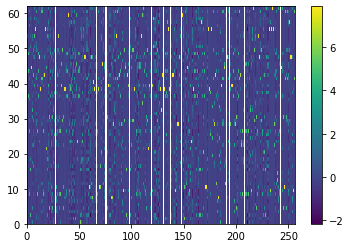

In [25]:
import scipy.stats
import matplotlib.pyplot as plt
plt.figure();
plt.pcolormesh(scipy.stats.zscore(f, axis=0))
plt.colorbar()

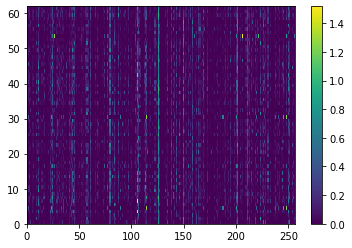

In [27]:
import matplotlib.pyplot as plt
plt.figure();
plt.pcolormesh(f)
plt.colorbar()

In [37]:
np.any(np.isinf(fz[0,:]))

False

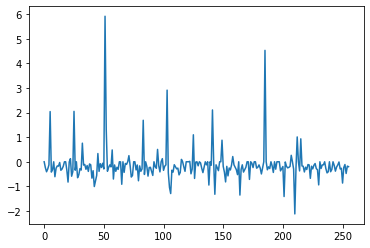

In [35]:
plt.figure();
plt.plot(fz[0,:])

In [30]:
f.shape

torch.Size([62, 256])

In [6]:
prf_pars = out['best_params'][0][:,0,:]
zeros = (prf_pars[:,0]==0.0) & (prf_pars[:,1]==0.0)
bad = np.where((prf_pars[:,0]==0.0) & (prf_pars[:,1]==0.0))[0]

In [5]:
out = torch.load('/user_data/mmhender/imStat/model_fits/S01/alexnet_Conv5/Oct-22-2021_1919_16/all_fit_params')


In [9]:
bodylabs = voxel_roi[3][voxel_mask]
np.unique(bodylabs[bad])
# np.where(bodylabs)

array([-1.,  0.,  1.,  2.,  3.])

In [10]:
vind = np.where(zeros & (voxel_roi[3][voxel_mask]==3))[0][0]
vind

15268

In [11]:
mind = out['best_params'][5][vind,0]
mind

866

In [14]:
models[mind,:]

array([0.        , 0.        , 0.28787428])

In [58]:
models[852,:]

array([ 0.18333333, -0.18333333,  0.207179  ])

In [51]:
counts = np.array([np.sum(out['best_params'][5][:,0]==mm) for mm in range(875)])
print(np.where(counts==0))
badmodels = np.where(counts==0)
models[counts==0,:]

(array([ 21,  23,  32,  38, 357, 358, 361, 377, 378, 414, 416, 417, 428,
       439, 445, 518, 578, 592, 595, 596, 605, 609, 611, 620, 624, 635,
       690, 733, 734, 743]),)


array([[-0.49210526, -0.49210526,  0.04      ],
       [-0.37631579, -0.49210526,  0.04      ],
       [ 0.14473684, -0.49210526,  0.04      ],
       [ 0.49210526, -0.49210526,  0.04      ],
       [ 0.43421053,  0.43421053,  0.04      ],
       [ 0.49210526,  0.43421053,  0.04      ],
       [-0.49210526,  0.49210526,  0.04      ],
       [ 0.43421053,  0.49210526,  0.04      ],
       [ 0.49210526,  0.49210526,  0.04      ],
       [ 0.55      , -0.55      ,  0.05557982],
       [-0.47142857, -0.47142857,  0.05557982],
       [-0.39285714, -0.47142857,  0.05557982],
       [ 0.47142857, -0.47142857,  0.05557982],
       [ 0.15714286, -0.39285714,  0.05557982],
       [-0.55      , -0.31428571,  0.05557982],
       [ 0.47142857,  0.        ,  0.05557982],
       [ 0.47142857,  0.31428571,  0.05557982],
       [ 0.39285714,  0.39285714,  0.05557982],
       [-0.55      ,  0.47142857,  0.05557982],
       [-0.47142857,  0.47142857,  0.05557982],
       [ 0.23571429,  0.47142857,  0.055

In [75]:
masks, names = _feature_extractor.get_partial_versions()

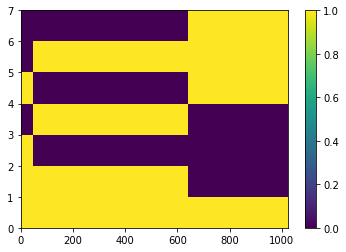

In [76]:
plt.figure();
plt.pcolormesh(masks)
plt.colorbar()

In [77]:
names

['full_combined_model',
 'just_pyramid_texture',
 'pyramid_texture_just_lower-level_no_other_modules',
 'pyramid_texture_just_higher-level_no_other_modules',
 'pyramid_texture_just_lower-level_plus_other_modules',
 'pyramid_texture_just_higher-level_plus_other_modules',
 'just_alexnet']

In [78]:
f, defined = _feature_extractor(image_order_val, models[207,:], 207, fitting_mode = True)

Loading pre-computed features for models [200 - 249] from /user_data/mmhender/features/pyramid_texture/S1_features_each_prf_4ori_4sf.h5py
Took 94.38337 seconds to load file
Size of features array for this batch is:
(62, 641, 50)
Index into batch for prf 207: 7
Size of features array for this image set and prf is:
(62, 641)
Final size of features concatenated is [62 x 641]
Feature types included are:
['pixel_stats', 'mean_magnitudes', 'mean_realparts', 'marginal_stats_lowpass_recons', 'variance_highpass_resid', 'magnitude_feature_autocorrs', 'lowpass_recon_autocorrs', 'highpass_resid_autocorrs', 'magnitude_within_scale_crosscorrs', 'real_within_scale_crosscorrs', 'magnitude_across_scale_crosscorrs', 'real_imag_across_scale_crosscorrs', 'real_spatshift_within_scale_crosscorrs', 'real_spatshift_across_scale_crosscorrs']
Final size of features concatenated is [62 x 641]
Final size of features concatenated is [62 x 641]
Loading pre-computed features for models [200 - 299] from /user_data/mm

/home/mmhender/myenv/lib/python3.7/site-packages/scipy/stats/stats.py:2568: RuntimeWarning: divide by zero encountered in true_divide
  z = (a - mn) / std


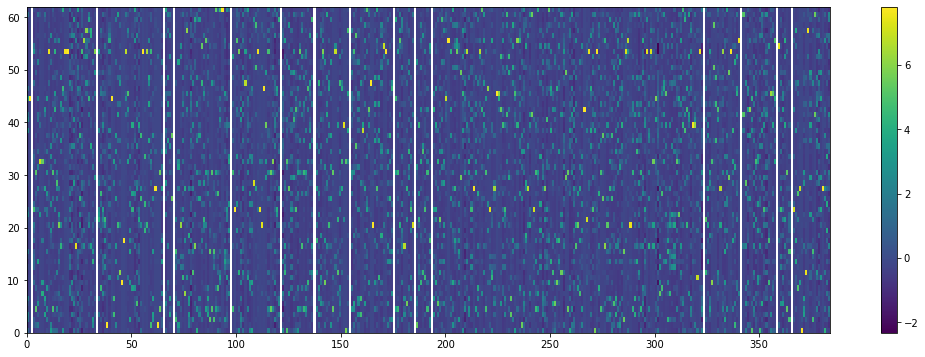

In [94]:
import scipy.stats
import matplotlib.pyplot as plt
plt.figure(figsize=(18,6));
# plt.pcolormesh(f[:,641:]);
plt.pcolormesh(scipy.stats.zscore(f[:,641:], axis=0));
plt.colorbar()

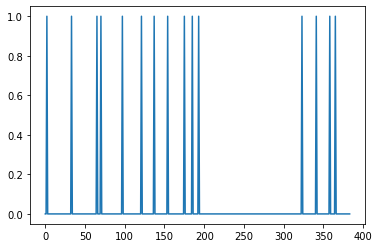

In [98]:
plt.figure();
plt.plot(np.std(f[:,641:].detach().cpu().numpy(), axis=0)==0.0)

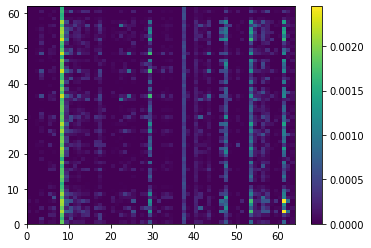

In [25]:
import matplotlib.pyplot as plt
plt.figure();
plt.pcolormesh(f);
plt.colorbar()

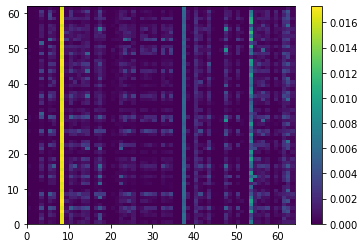

In [27]:
import matplotlib.pyplot as plt
plt.figure();
plt.pcolormesh(f);
plt.colorbar()

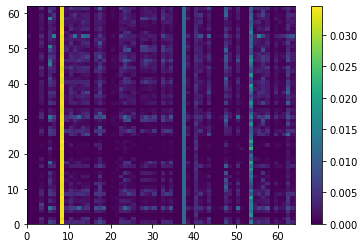

In [29]:
import matplotlib.pyplot as plt
plt.figure();
plt.pcolormesh(f);
plt.colorbar()

In [11]:
import numpy as np
import sys, os
import time
import h5py
import torch.nn as nn


from utils import default_paths, torch_utils
alexnet_feat_path = default_paths.alexnet_feat_path
from feature_extraction import extract_alexnet_features
alexnet_layer_names  = extract_alexnet_features.alexnet_layer_names
n_features_each_layer = extract_alexnet_features.n_features_each_layer

class alexnet_feature_extractor(nn.Module):
    
    def __init__(self, subject, layer_name, device):
        
        super(alexnet_feature_extractor, self).__init__()
        
        self.subject = subject       
        self.layer_name = layer_name
        self.features_file = os.path.join(alexnet_feat_path, 'S%d_%s_features_each_prf.h5py'%(subject, self.layer_name))
        layer_ind = [ll for ll in range(len(alexnet_layer_names)) \
                         if alexnet_layer_names[ll]==self.layer_name]
        assert(len(layer_ind)==1)
        layer_ind = layer_ind[0]
        
        self.n_features = n_features_each_layer[layer_ind]
        if not os.path.exists(self.features_file):
            raise RuntimeError('Looking at %s for precomputed features, not found.'%self.features_file)

        self.device = device
        self.do_varpart=False # only one set of features in this model for now, not doing variance partition

        self.prf_batch_size=100
        self.features_each_prf_batch = None
        self.prf_inds_loaded = []
        
    def init_for_fitting(self, image_size, models, dtype):

        """
        Additional initialization operations.
        """        
        print('Initializing for fitting')
        self.max_features = self.n_features
        
        # Prepare for loading the pre-computed features: as a 
        # compromise between speed and ram usage, will load them in
        # batches of multiple prfs at a time. 
        n_prfs = models.shape[0]
        n_prf_batches = int(np.ceil(n_prfs/self.prf_batch_size))          
        self.prf_batch_inds = [np.arange(self.prf_batch_size*bb, np.min([self.prf_batch_size*(bb+1), n_prfs])) \
                               for bb in range(n_prf_batches)]
       
        self.clear_big_features()
        
    def get_partial_versions(self):

        if not hasattr(self, 'max_features'):
            raise RuntimeError('need to run init_for_fitting first')
           
        partial_version_names = ['full_model']
        masks = np.ones([1,self.max_features])

        return masks, partial_version_names

    def load_precomputed_features(self, image_inds, prf_model_index):
        
        if prf_model_index not in self.prf_inds_loaded:
            
            batch_to_use = np.where([prf_model_index in self.prf_batch_inds[bb] for \
                                         bb in range(len(self.prf_batch_inds))])[0][0]
            assert(prf_model_index in self.prf_batch_inds[batch_to_use])
            self.prf_inds_loaded = self.prf_batch_inds[batch_to_use]
            print('Loading pre-computed features for models [%d - %d] from %s'%(self.prf_batch_inds[batch_to_use][0], \
                                                                              self.prf_batch_inds[batch_to_use][-1], self.features_file))
            self.features_each_prf_batch = None
        
            gc.collect()
            torch.cuda.empty_cache()

            t = time.time()

            # Loading raw features.
            with h5py.File(self.features_file, 'r') as data_set:
                values = np.copy(data_set['/features'][:,:,self.prf_batch_inds[batch_to_use]])
                data_set.close() 
            elapsed = time.time() - t
            print('Took %.5f seconds to load file'%elapsed)

            self.features_each_prf_batch = values[image_inds,:,:]
            values=None
            assert(self.n_features==self.features_each_prf_batch.shape[1])
        
            print('Size of features array for this batch, is:')
            print(self.features_each_prf_batch.shape)
            
        else:
            assert(len(image_inds)==self.features_each_prf_batch.shape[0])
            
        index_into_batch = np.where(prf_model_index==self.prf_inds_loaded)[0][0]
        print('Index into batch for prf %d: %d'%(prf_model_index, index_into_batch))
        features_in_prf = self.features_each_prf_batch[:,:,index_into_batch]
        
        print('Size of features array for this image set and prf is:')
        print(features_in_prf.shape)
        
        return features_in_prf
        

    def clear_big_features(self):
        
        print('Clearing features from memory')
        self.features_each_prf_batch = None 
        self.prf_inds_loaded = []
        gc.collect()
        torch.cuda.empty_cache()
    
    def forward(self, image_inds, prf_params, prf_model_index, fitting_mode = True):
         
        features = self.load_precomputed_features(image_inds, prf_model_index)

        assert(features.shape[0]==len(image_inds))
        print('Final size of feature matrix is:')
        print(features.shape)
        
        features = torch_utils._to_torch(features, self.device)
        
        feature_inds_defined = np.zeros((self.max_features,), dtype=bool)
        feature_inds_defined[0:features.shape[1]] = 1
            
        return features, feature_inds_defined
 